# **Distance Predictor Part 5**
Author: Declan Costello

Date: 8/19/2023

## **Part 5 Description**

Here I Create pipelines with hyperparameter tuning Imputation, Scalling, One Hot encoding, and then use grid search for hyper parameter tuning utilizing the new features created in part 3

## **Table of Context**

1. [Installation](#Installation)
2. [Final Pipeline](#final-pipeline)
3. [Results](#Results)

**Installation**
- The following installs the necessary packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import set_config
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
import joblib
import bz2

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import simps
from matplotlib.font_manager import FontProperties

In [4]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import row, column
from bokeh.layouts import gridplot
output_notebook()

Loading BokehJS ...

**Data Import**

In [5]:
data = pd.read_csv('FE_data.csv')

In [6]:
data.groupby('events').size()

events
double        8183
field_out    75409
home_run      5366
single       26547
triple         649
dtype: int64

In [7]:
data['events'].value_counts

<bound method IndexOpsMixin.value_counts of 0         field_out
1            double
2         field_out
3         field_out
4            single
            ...    
116149    field_out
116150    field_out
116151       single
116152       single
116153    field_out
Name: events, Length: 116154, dtype: object>

**Preprocessing**

In [8]:
numeric_features = ['launch_angle','launch_speed','pfx_x','pfx_z',"release_speed", "domed", "spray_angle",'is_barrel','Pop','pull_percent']
numeric_transformer = Pipeline(steps=[
    ("scaler", RobustScaler())
])


categorical_features = ["home_team","stand","p_throws",'grouped_pitch_type','fav_platoon_split_for_batter']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")


preprocessor = ColumnTransformer(transformers=[
    ("num_transform", numeric_transformer, numeric_features),
    ("cat_transform", categorical_transformer, categorical_features)
])

**Pipelines for Ensemble**

In [9]:
XGBRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("Random Forest Regressor", XGBRegressor(XGB__learning_rate=0.1, max_depth=5, min_child_weight = 1, subsample = 1.0, n_estimators=10))])

RandomForestRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("rf", RandomForestRegressor())])

MLPRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("MLPR", MLPRegressor())])

GradientBoostingRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("gbr", GradientBoostingRegressor())])

**Train Test Split**

In [10]:
feature_cols = ['launch_angle','launch_speed','pfx_x','pfx_z',"release_speed","home_team","stand","p_throws","fav_platoon_split_for_batter","grouped_pitch_type", "domed", "spray_angle",'is_barrel','Pop','pull_percent']
X = data.loc[:, feature_cols]

target_cols = ['hit_distance_sc']
y = data.loc[:, target_cols]

**[Stratify](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)**
- [I can only stratify three features because only working with ~100k rows](https://github.com/davidsbatista/text-classification/issues/1)
- [Eventual StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html)

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.95, test_size=0.05,random_state=0,stratify = X[['home_team',"stand",'grouped_pitch_type']])

**VotingRegressor**
- Finally, we will visualize the predictions. The red stars show the average prediction made by VotingRegressor.

In [12]:
er = VotingRegressor([('ogxg', XGBRegressor_pipeline), ('MLPR', MLPRegressor_pipeline),('gbr',GradientBoostingRegressor_pipeline),('rf', RandomForestRegressor_pipeline)])
er.fit(X_train, y_train.values.ravel())

preds = er.predict(X_valid)

predicted_distance = list(preds)
actual_distance = y_valid['hit_distance_sc'].to_list()

[21:01:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "XGB__learning_rate" } are not used.



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


**Most Important [Features](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.Booster.get_score) for Main Pipeline**

In [13]:
XGBRegressor_pipeline.fit(X_train, y_train.values.ravel())

coef = pd.Series(list(XGBRegressor_pipeline.steps[1][1].feature_importances_)[:10], index = X_train.columns[:10]).sort_values(ascending=True)
coef = coef.to_frame()
names = list(coef.index)
coef = coef.rename(columns={0: 'values'})
values = coef['values']

z = figure(y_range=names, height=500, width=500,title="Feature Importance")
z.hbar(y=names, right=values, width=0.9, color='skyblue')
z.x_range.start = 0
z.x_range.end = .9
z.xaxis.major_label_orientation = 1

p = figure(y_range=names[:7], height=500, width=500,title="Feature Importance")

p.hbar(y=names[:7], right=values[:7], width=0.9, color='skyblue')

p.x_range.start = 0
p.x_range.end = .012
p.xaxis.major_label_orientation = 1


show(row(z,p))

[21:04:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "XGB__learning_rate" } are not used.



**Actual vs Predicted**

In [14]:
predicted_distance = list(preds)
actual_distance = y_valid['hit_distance_sc'].to_list()

final_pipe_results = pd.DataFrame()

final_pipe_results['predicted_distance'] = predicted_distance

final_pipe_results['actual_distance'] = actual_distance

final_pipe_results['residual'] = final_pipe_results['actual_distance'] - final_pipe_results['predicted_distance']

p = figure(height=500, width=500,title="Predicted vs Actual Distance")
p.circle(actual_distance, predicted_distance, size=5, line_color="skyblue", fill_color="skyblue", fill_alpha=0.3)
p.xaxis.axis_label = 'Actual Distance'
p.yaxis.axis_label = 'Predicted distance'

z = figure(height=500, width=500,title="Residual vs Predicted Distance")
z.circle(final_pipe_results.predicted_distance, final_pipe_results.residual, size=5, line_color="skyblue", fill_color="skyblue", fill_alpha=0.3)
z.xaxis.axis_label = 'Predicted Distance'
z.yaxis.axis_label = 'Residual (actual - predicted)'

b = figure(width=1000, height=500, toolbar_location=None,
           title="Normality of Residuals")

# Histogram
bins = np.linspace(-50, 50, 100)
hist, edges = np.histogram(final_pipe_results.residual, density=True, bins=bins)
b.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
         fill_color="skyblue", line_color="white")

b.y_range.start = 0
b.x_range.start = -20
b.x_range.end = 20

b.xaxis.axis_label = "Residuals"
b.yaxis.axis_label = "Distribution Count"

grid = gridplot([[row(p, z)], 
                 [b]])
show(grid)

**Confusion Matrix**

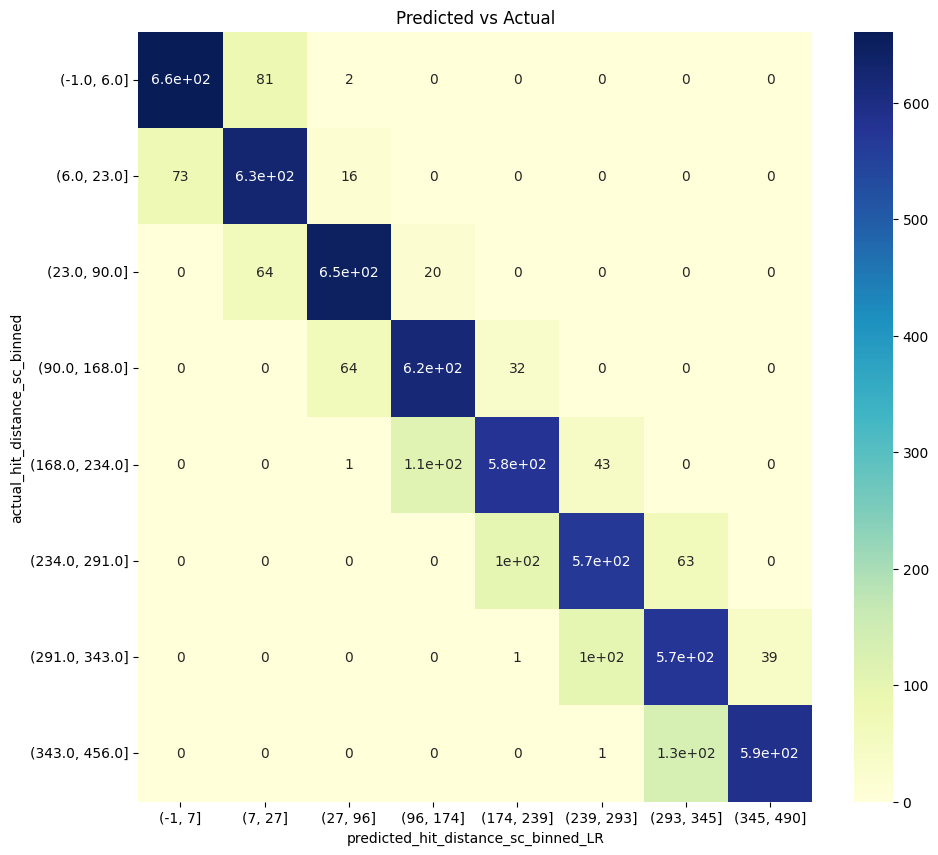

In [15]:
y_valid['actual_hit_distance_sc_binned'] = pd.qcut(y_valid['hit_distance_sc'], q=8, precision=0)
y_valid = y_valid.reset_index()
y_valid = y_valid.reset_index()
y_valid = y_valid.rename(columns={'level_0': 'key'})


df_predicted_LR = pd.DataFrame(predicted_distance, columns=['predicted_hit_distance_sc'])
bins = [-1, 7, 27, 96, 174, 239, 293, 345, 490]
df_predicted_LR['predicted_hit_distance_sc_binned_LR'] = pd.cut(df_predicted_LR['predicted_hit_distance_sc'], bins)
df_predicted__LR = df_predicted_LR.reset_index()
df_predicted__LR = df_predicted__LR.rename(columns={'index': 'key'})
result_2 = pd.merge(y_valid, df_predicted__LR, on="key")
result_2_heatmap = result_2.pivot_table(index='actual_hit_distance_sc_binned', columns='predicted_hit_distance_sc_binned_LR', aggfunc='count')


plt.figure(figsize=(50,10))
plt.subplot(141)
sns.heatmap(result_2_heatmap['hit_distance_sc'],cmap="YlGnBu",annot=True)
plt.title('Predicted vs Actual')
plt.show()


In [16]:
final_vars = X_valid.head(153550)
f = final_vars.iloc[1142]
final_vars = f.to_frame().T

# **Saving Model**

In [17]:
# Compress the model using bz2 and save it with joblib
with bz2.BZ2File('compressed_9_model.joblib.bz2', 'wb', compresslevel=9) as f:
    joblib.dump(er, f)


# **Loading Model**

In [18]:
#load saved compressed model
with bz2.BZ2File('compressed_9_model.joblib.bz2', 'rb') as f:
    lo_mo = joblib.load(f)

preds = lo_mo.predict(final_vars)
preds[0]

170.20560675185828

# **Model Use Case**

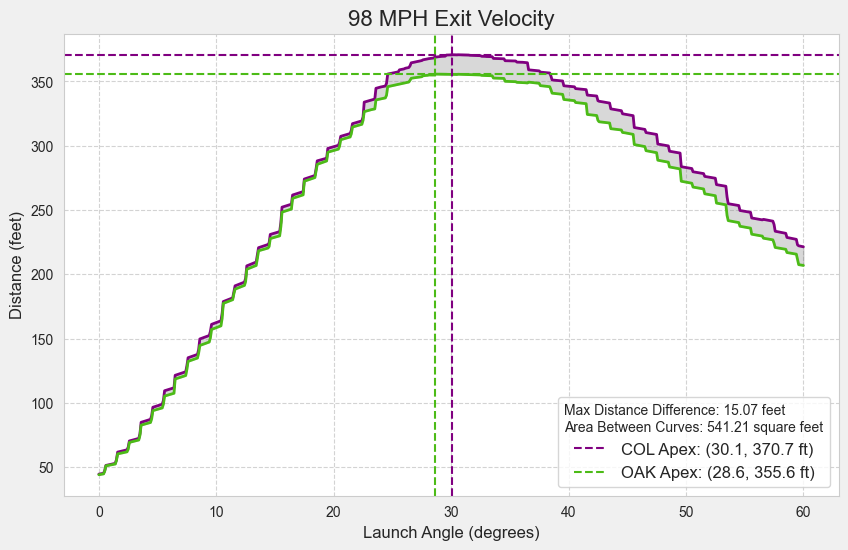

In [22]:
def model_chart(speed, team1, team2):
    final_vars['launch_speed'] = speed
    final_vars['home_team'] = str(team1)

    # Customize grid style
    sns.set_style("whitegrid", {"grid.linestyle": "--", "grid.color": "lightgray"})


    list_of_launch_angles = [round(x * 0.1, 1) for x in range(0, 601)]

    team1_distances = []

    for i in list_of_launch_angles:
        final_vars['launch_angle'] = i
        preds = lo_mo.predict(final_vars)
        team1_distances.append(preds[0])

    final_vars['home_team'] = str(team2)

    team2_distances = []

    for i in list_of_launch_angles:
        final_vars['launch_angle'] = i
        preds = lo_mo.predict(final_vars)
        team2_distances.append(preds[0])

    model_res_pd = pd.DataFrame(np.column_stack([list_of_launch_angles, team1_distances, team2_distances]),
                                columns=['Launch_Angles', str(team1), str(team2)])

    # Create a figure and axis using Seaborn with custom background color
    plt.figure(figsize=(10, 6), facecolor='#f0f0f0')
    
    # Define new colors
    team1_color = 'purple'
    team2_color = '#4CBB17'
    
    # Define new fonts
    title_font = {'fontname': 'Arial', 'fontsize': 16}
    label_font = {'fontname': 'Arial', 'fontsize': 12}
    
    ax = sns.lineplot(data=model_res_pd, x='Launch_Angles', y=str(team1), color=team1_color, linewidth=2)
    sns.lineplot(data=model_res_pd, x='Launch_Angles', y=str(team2), color=team2_color, linewidth=2)

    # Calculate apex points for y1 (team1)
    apex_x1 = model_res_pd['Launch_Angles'][model_res_pd[str(team1)].idxmax()]
    apex_y1 = model_res_pd[str(team1)].max()

    # Calculate apex points for y2 (team2)
    apex_x2 = model_res_pd['Launch_Angles'][model_res_pd[str(team2)].idxmax()]
    apex_y2 = model_res_pd[str(team2)].max()

    # Calculate the difference in max distances
    distance_difference = abs(apex_y1 - apex_y2)

    # Add horizontal lines at the apex points
    ax.axhline(y=apex_y1, color=team1_color, linestyle='--')
    ax.axhline(y=apex_y2, color=team2_color, linestyle='--')

    # # Add vertical lines at the apex points
    # ax.axvline(x=apex_x1, color=team1_color, linestyle='--', label=f'{str(team1)} Apex')
    # ax.axvline(x=apex_x2, color=team2_color, linestyle='--', label=f'{str(team2)} Apex')

    # Add vertical lines at the apex points with labels including coordinates
    ax.axvline(x=apex_x1, color=team1_color, linestyle='--', label=f'{str(team1)} Apex: ({apex_x1:.1f}, {apex_y1:.1f} ft)')
    ax.axvline(x=apex_x2, color=team2_color, linestyle='--', label=f'{str(team2)} Apex: ({apex_x2:.1f}, {apex_y2:.1f} ft)')


    # Fill the area between the curves
    ax.fill_between(model_res_pd['Launch_Angles'], team1_distances, team2_distances, color='gray', alpha=0.3)

    # Calculate the area between the curves using Simpson's rule (numerical integration)
    area_between_curves = simps(np.abs(np.array(team1_distances) - np.array(team2_distances)), list_of_launch_angles)

    # Set labels and title with custom fonts
    ax.set_xlabel('Launch Angle (degrees)', **label_font)
    ax.set_ylabel('Distance (feet)', **label_font)
    ax.set_title(f'{speed} MPH Exit Velocity', **title_font)

    # Add the difference in distances and area to the legend as the title
    legend = ax.legend(prop=FontProperties(family='Arial', size=12))
    legend.set_title(f'Max Distance Difference: {distance_difference:.2f} feet \nArea Between Curves: {area_between_curves:.2f} square feet')
    
    # Show the plot
    plt.show()


# Call the function with your desired arguments
model_chart(98, 'COL', 'OAK')
